## Step 0: Latent Dirichlet Allocation ##

LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

* Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.
* LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial.
* It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution.

## Step 1: Load the dataset

The dataset we'll use is a list of over one million news headlines published over a period of 15 years. We'll start by loading it from the `abcnews-date-text.csv` file.

In [ ]:
!pip install pandas

In [ ]:
'''
Load the dataset from the CSV and save it to 'data_text'
'''
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

data = pd.read_csv('npr.csv',encoding='latin-1'); # error_bad_lines=False
data.head()

<ipython-input-2-c67030487c37>:8: DtypeWarning: Columns (17,19,21,23,25,27,29,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('npr.csv',encoding='latin-1'); # error_bad_lines=False


,id,page_id,,name,.1,message,.2,description,.3,caption,.4,post_type,.5,status_type,.6,likes_count,.7,comments_count,.8,shares_count,.9,love_count,.10,wow_count,.11,haha_count,.12,sad_count,.13,thankful_count,.14,angry_count,.15,link,.16,picture,.17,posted_at,\t\t\t,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42
0,_,10643211755_255251391226420,,10643211755,,From KPLU: Why most people get divorced in March,,,,Divorce is a nasty business and this time of t...,,kplu.org,,link,,shared_story,,538,,244,,525,,0,,0,,0,,0,,0,,0,,http://www.kplu.org/post/why-most-people-get-d...,,https://external.xx.fbcdn.net/safe_image.php?d...,,3/7/12 12:50,\t\t\t,NaN,NaN
1,_,10643211755_388881894474609,,10643211755,,How Do You Ship A Horse To The London Olympics...,,,,The elite athletes who travel to London for th...,,npr.org,,link,,shared_story,,1507,,132,,1349,,0,,0,,0,,0,,0,,0,,http://www.npr.org/blogs/thetwo-way/2012/03/07...,,https://external.xx.fbcdn.net/safe_image.php?d...,,3/7/12 14:17,\t\t\t,NaN,NaN
2,_,10643211755_414455961905074,,10643211755,,Unmarked: Ordinary Scenes With Unsettling Stories,,,,These photos seem like perfectly quiet Ñ beaut...,,npr.org,,link,,shared_story,,863,,173,,509,,0,,0,,0,,0,,0,,0,,http://www.npr.org/blogs/pictureshow/2012/03/0...,,https://external.xx.fbcdn.net/safe_image.php?d...,,3/7/12 15:26,\t\t\t,NaN,NaN
3,_,10643211755_284468938293046,,10643211755,,The Three Little Pigs And The Future Of Journa...,,,,In an action-packed two-minute remake of the...,,npr.org,,link,,shared_story,,668,,53,,491,,0,,0,,0,,0,,0,,0,,http://www.npr.org/blogs/krulwich/2012/03/05/1...,,https://external.xx.fbcdn.net/safe_image.php?d...,,3/7/12 16:42,\t\t\t,NaN,NaN
4,_,10643211755_242967482460231,,10643211755,,Double Take 'Toons: Close Enough For Govt. Work?,,,,Mitt Romney won six of 10 states on Super Tues...,,npr.org,,link,,shared_story,,299,,36,,75,,0,,0,,0,,0,,0,,0,,http://www.npr.org/2012/03/07/148129721/close-...,,https://external.xx.fbcdn.net/safe_image.php?d...,,3/7/12 18:14,\t\t\t,NaN,NaN


In [ ]:
data[['caption']].values[0]

array(['Divorce is a nasty business and this time of the year business is booming. KPLU looks at the reasons divorce filings peak in March every year.'],
      dtype=object)

In [ ]:
# We only need the Headlines text column from the data
data_text = data[['caption']];
data_text['index'] = data_text.index

documents = data_text

<ipython-input-4-3866117b49df>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_text['index'] = data_text.index


**Let's glance at the dataset:**

In [ ]:
'''
Get the total number of documents
'''
print(len(documents))

36299


In [ ]:
documents[:5]

,caption,index
0,Divorce is a nasty business and this time of t...,0
1,The elite athletes who travel to London for th...,1
2,These photos seem like perfectly quiet Ñ beaut...,2
3,In an action-packed two-minute remake of the...,3
4,Mitt Romney won six of 10 states on Super Tues...,4


## Step 2: Data Preprocessing ##

We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** - words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** - words are reduced to their root form.


In [ ]:
!pip install gensim nltk

In [ ]:
'''
Loading Gensim and nltk libraries
'''
# pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Lemmatizer Example
Before preprocessing our dataset, let's first look at an lemmatizing example. What would be the output if we lemmatized the word 'went':

In [ ]:
print(WordNetLemmatizer().lemmatize('went', pos = 'v')) # past tense to present tense

go


### Stemmer Example
Let's also look at a stemming example. Let's throw a number of words at the stemmer and see how it deals with each one:

In [ ]:
stemmer = SnowballStemmer("english")
original_words = ['flies', 'dies', 'denied','died', 'agreed', 'owned',
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational',
           'traditional', 'reference', 'colonizer','plotted']

singles = [stemmer.stem(plural) for plural in original_words]

pd.DataFrame(data={'original word':original_words, 'stemmed':singles })

,original word,stemmed
0,flies,fli
1,dies,die
2,denied,deni
3,died,die
4,agreed,agre
5,owned,own
6,humbled,humbl
7,sized,size
8,meeting,meet
9,stating,state


In [ ]:
'''
Write a function to perform the pre processing steps on the entire dataset
'''
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :   # tokenization,lowercasing, removing punctuation, removing short words
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            #Apply lemmatize_stemming() on the token, then add to the results list
            result.append(lemmatize_stemming(token))

    return result



In [ ]:
'''
Preview a document after preprocessing
'''
document_num = 4310
doc_sample = documents[documents['index'] == document_num].values[0][0]

doc_sample

'Fairness Campaign Director Chris Hartman left at about 11:30 p.m. and discovered that his car parked near the Ali Center had been sideswiped while parked on the streetÑthe mirror damaged   the side dented and scratched. He called Louisville Metro Police to file an accident report.Officers noticed mor...'

In [ ]:
print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['Fairness', 'Campaign', 'Director', 'Chris', 'Hartman', 'left', 'at', 'about', '11:30', 'p.m.', 'and', 'discovered', 'that', 'his', 'car', 'parked', 'near', 'the', 'Ali', 'Center', 'had', 'been', 'sideswiped', 'while', 'parked', 'on', 'the', 'streetÑthe', 'mirror', 'damaged', '', '', 'the', 'side', 'dented', 'and', 'scratched.', 'He', 'called', 'Louisville', 'Metro', 'Police', 'to', 'file', 'an', 'accident', 'report.Officers', 'noticed', 'mor...']


Tokenized and lemmatized document: 
['fairness', 'campaign', 'director', 'chris', 'hartman', 'leave', 'discover', 'park', 'near', 'center', 'sideswipe', 'park', 'streetñthe', 'mirror', 'damage', 'dent', 'scratch', 'call', 'louisville', 'metro', 'police', 'file', 'accident', 'report', 'officer', 'notice']


In [ ]:
documents

,caption,index
0,Divorce is a nasty business and this time of t...,0
1,The elite athletes who travel to London for th...,1
2,These photos seem like perfectly quiet Ñ beaut...,2
3,In an action-packed two-minute remake of the...,3
4,Mitt Romney won six of 10 states on Super Tues...,4
...,...,...
36294,,36294
36295,Millions of Americans will vote for the next U...,36295
36296,From the waste-not ethos behind Angel Food Cak...,36296
36297,The high cost of child care is a strain for ma...,36297


Let's now preprocess all the news headlines we have. To do that, let's use the [map](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) function from pandas to apply `preprocess()` to the `headline_text` column

**Note**: This may take a few minutes (it take 6 minutes on my laptop)

In [ ]:
# TODO: preprocess all the headlines, saving the list of results as 'processed_docs'
processed_docs = documents['caption'].map(lambda x: preprocess(x))

In [ ]:
'''
Preview 'processed_docs'
'''
processed_docs[:10]

,caption
0,"[divorce, nasty, business, time, year, busines..."
1,"[elite, athletes, travel, london, summer, olym..."
2,"[photos, like, perfectly, quiet, beautiful, la..."
3,"[action, pack, minute, remake, classic, tale, ..."
4,"[mitt, romney, state, super, tuesday, accord, ..."
5,"[hashtag, term, stopkony, trend, twitter, redd..."
6,"[reality, invent, mind, truths, grasp, questio..."
7,"[princeton, religious, scholar, elaine, pagels..."
8,"[eject, huge, solar, flare, tuesday, nasa, say..."
9,"[eat, lot, fruit, veggies, give, skin, slightl..."


## Step 3.1: Bag of words on the dataset

Now let's create a dictionary from 'processed_docs' containing the number of times a word appears in the training set. To do that, let's pass `processed_docs` to [`gensim.corpora.Dictionary()`](https://radimrehurek.com/gensim/corpora/dictionary.html) and call it '`dictionary`'.

In [ ]:
'''
Create a dictionary from 'processed_docs' containing the number of times a word appears
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''
dictionary = gensim.corpora.Dictionary(processed_docs)

In [ ]:
'''
Checking dictionary created
'''
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 boom
1 business
2 divorce
3 file
4 kplu
5 look
6 march
7 nasty
8 peak
9 reason
10 time


In [ ]:
print(dictionary)

Dictionary<29940 unique tokens: ['boom', 'business', 'divorce', 'file', 'kplu']...>


In [ ]:
from collections import Counter
count = Counter()
for doc in processed_docs:
    for word in doc:
        count[word]+=1
print(count)

Counter({'say': 3383, 'people': 2058, 'year': 1710, 'state': 1621, 'years': 1528, 'time': 1522, 'like': 1361, 'help': 1293, 'world': 1203, 'work': 1202, 'come': 1129, 'live': 1098, 'know': 1041, 'change': 981, 'school': 972, 'city': 960, 'look': 936, 'take': 923, 'music': 838, 'women': 827, 'book': 818, 'week': 816, 'president': 814, 'life': 801, 'want': 795, 'health': 794, 'american': 781, 'go': 773, 'call': 772, 'study': 755, 'think': 735, 'home': 729, 'country': 724, 'tell': 720, 'food': 719, 'long': 718, 'play': 650, 'make': 644, 'turn': 626, 'high': 622, 'group': 600, 'trump': 596, 'national': 595, 'story': 590, 'report': 589, 'leave': 578, 'show': 573, 'students': 573, 'talk': 572, 'house': 560, 'right': 560, 'include': 557, 'police': 555, 'company': 549, 'get': 542, 'start': 541, 'need': 532, 'question': 531, 'public': 531, 'grow': 530, 'try': 522, 'young': 517, 'mean': 507, 'plan': 504, 'children': 496, 'find': 492, 'bring': 490, 'history': 489, 'place': 485, 'game': 482, 'blac

In [ ]:
print(count['year'])

1710


In [ ]:
len(count)

29940

**Gensim filter_extremes**

[`filter_extremes(no_below=5, no_above=0.5, keep_n=100000)`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes)

Filter out tokens that appear in

* less than no_below documents (absolute number) or
* more than no_above documents (fraction of total corpus size, not absolute number).
* after (1) and (2), keep only the first keep_n most frequent tokens (or keep all if None).

In [ ]:
'''
OPTIONAL STEP
Remove very rare and very common words:

- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
# TODO: apply dictionary.filter_extremes() with the parameters mentioned above
dictionary.filter_extremes(no_below=10, no_above=0.1, keep_n=100000)

In [ ]:
len(dictionary)

5452

**Gensim doc2bow**

[`doc2bow(document)`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow)

* Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.

In [ ]:
'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
# TODO
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [ ]:
'''
Checking Bag of Words corpus for our sample document --> (token_id, token_count)
'''
bow_corpus[document_num]

[(3, 1),
 (57, 1),
 (232, 1),
 (249, 1),
 (630, 1),
 (644, 1),
 (896, 1),
 (995, 1),
 (1085, 1),
 (1273, 1),
 (1280, 2),
 (1406, 1),
 (1427, 1),
 (1435, 1),
 (1686, 1),
 (2334, 1),
 (2721, 1),
 (3277, 1),
 (4408, 1),
 (4653, 1)]

In [ ]:
'''
Preview BOW for our sample preprocessed document
'''
# Here document_num is document number 4310 which we have checked in Step 2
bow_doc_4310 = bow_corpus[document_num]

for i in range(len(bow_doc_4310)):
    print(f"Word {bow_doc_4310[i][0]} ({dictionary[bow_doc_4310[i][0]]}) appears {bow_doc_4310[i][1]} time.")

Word 3 (file) appears 1 time.
Word 57 (chris) appears 1 time.
Word 232 (report) appears 1 time.
Word 249 (accident) appears 1 time.
Word 630 (near) appears 1 time.
Word 644 (notice) appears 1 time.
Word 896 (leave) appears 1 time.
Word 995 (campaign) appears 1 time.
Word 1085 (scratch) appears 1 time.
Word 1273 (call) appears 1 time.
Word 1280 (park) appears 2 time.
Word 1406 (police) appears 1 time.
Word 1427 (center) appears 1 time.
Word 1435 (discover) appears 1 time.
Word 1686 (director) appears 1 time.
Word 2334 (mirror) appears 1 time.
Word 2721 (officer) appears 1 time.
Word 3277 (damage) appears 1 time.
Word 4408 (louisville) appears 1 time.
Word 4653 (metro) appears 1 time.


## Step 3.2: TF-IDF on our document set ##

While performing TF-IDF on the corpus is not necessary for LDA implemention using the gensim model, it is recemmended. TF-IDF expects a bag-of-words (integer values) training corpus during initialization. During transformation, it will take a vector and return another vector of the same dimensionality.

*Please note: The author of Gensim dictates the standard procedure for LDA to be using the Bag of Words model.*

** TF-IDF stands for "Term Frequency, Inverse Document Frequency".**

* It is a way to score the importance of words (or "terms") in a document based on how frequently they appear across multiple documents.
* If a word appears frequently in a document, it's important. Give the word a high score. But if a word appears in many documents, it's not a unique identifier. Give the word a low score.
* Therefore, common words like "the" and "for", which appear in many documents, will be scaled down. Words that appear frequently in a single document will be scaled up.

In other words:

* TF(w) = `(Number of times term w appears in a document) / (Total number of terms in the document)`.
* IDF(w) = `log_e(Total number of documents / Number of documents with term w in it)`.

** For example **

* Consider a document containing `100` words wherein the word 'tiger' appears 3 times.
* The term frequency (i.e., tf) for 'tiger' is then:
    - `TF = (3 / 100) = 0.03`.

* Now, assume we have `10 million` documents and the word 'tiger' appears in `1000` of these. Then, the inverse document frequency (i.e., idf) is calculated as:
    - `IDF = log(10,000,000 / 1,000) = 4`.

* Thus, the Tf-idf weight is the product of these quantities:
    - `TF-IDF = 0.03 * 4 = 0.12`.

In [ ]:
'''
Create tf-idf model object using models.TfidfModel on 'bow_corpus' and save it to 'tfidf'
'''
from gensim import corpora, models


tfidf = models.TfidfModel(bow_corpus)

In [ ]:
'''
Apply transformation to the entire corpus and call it 'corpus_tfidf'
'''

corpus_tfidf = tfidf[bow_corpus]

In [ ]:
'''
Preview TF-IDF scores for our first document --> --> (token_id, tfidf score)
'''
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.2577154894082945),
 (1, 0.4006663419997005),
 (2, 0.5878825298948878),
 (3, 0.23649391958911598),
 (4, 0.14682742977034272),
 (5, 0.2377479190711925),
 (6, 0.30156736857146865),
 (7, 0.28075943665672987),
 (8, 0.21386361024512032),
 (9, 0.1285651397643414),
 (10, 0.2477826079149068)]


## Step 4.1: Running LDA using Bag of Words ##

We are going for 10 topics in the document corpus.

**We will be running LDA using all CPU cores to parallelize and speed up model training.**

Some of the parameters we will be tweaking are:

* **num_topics** is the number of requested latent topics to be extracted from the training corpus.
* **id2word** is a mapping from word ids (integers) to words (strings). It is used to determine the vocabulary size, as well as for debugging and topic printing.
* **workers** is the number of extra processes to use for parallelization. Uses all available cores by default.


* **passes** is the number of training passes through the corpus.


In [ ]:
# LDA mono-core -- fallback code in case LdaMulticore throws an error on your machine
# lda_model = gensim.models.LdaModel(bow_corpus,
#                                    num_topics = 10,
#                                    id2word = dictionary,
#                                    passes = 50)

# LDA multicore
'''
Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model'
'''
# TODO
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 10, id2word = dictionary, passes = 5)

In [ ]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.013*"food" + 0.010*"like" + 0.008*"company" + 0.008*"look" + 0.008*"water" + 0.007*"city" + 0.007*"home" + 0.007*"sanders" + 0.007*"farm" + 0.006*"take"


Topic: 1 
Words: 0.011*"link" + 0.010*"change" + 0.007*"military" + 0.007*"say" + 0.007*"track" + 0.006*"team" + 0.006*"world" + 0.006*"thousands" + 0.006*"hundreds" + 0.006*"years"


Topic: 2 
Words: 0.028*"trump" + 0.023*"say" + 0.021*"president" + 0.017*"vote" + 0.016*"donald" + 0.015*"state" + 0.015*"campaign" + 0.013*"election" + 0.012*"court" + 0.011*"obama"


Topic: 3 
Words: 0.043*"clinton" + 0.025*"hillary" + 0.011*"test" + 0.011*"state" + 0.010*"doctor" + 0.010*"case" + 0.008*"sugar" + 0.008*"advice" + 0.008*"zika" + 0.007*"rat"


Topic: 4 
Words: 0.032*"say" + 0.015*"book" + 0.011*"world" + 0.009*"help" + 0.008*"work" + 0.007*"know" + 0.007*"people" + 0.007*"time" + 0.007*"read" + 0.007*"science"


Topic: 5 
Words: 0.020*"police" + 0.013*"shoot" + 0.011*"years" + 0.010*"say" + 0.010*"kill" + 0.010*"attac

### Classification of the topics ###

Using the words in each topic and their corresponding weights, what categories were you able to infer?

* 0: social, world news
* 1: Urgent issue / catastrophe
* 2: Accidents, wars, conflicts
* 3: Economy
* 4: Politics
* 5: Diplomacy
* 6: Agriculture
* 7: Sports
* 8: Justice
* 9: Claims, disputes

## Step 4.2 Running LDA using TF-IDF ##

In [ ]:
'''
Define lda model using corpus_tfidf, again using gensim.models.LdaMulticore()
'''
# TODO
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics = 10, id2word = dictionary, passes = 1)

In [ ]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model_tfidf.print_topics(-1):
    print("Topic: {} \nWord: {}".format(idx, topic))
    print("\n")

Topic: 0 
Word: 0.008*"vote" + 0.008*"ballot" + 0.006*"election" + 0.005*"people" + 0.005*"cast" + 0.004*"voters" + 0.004*"virus" + 0.004*"prison" + 0.004*"say" + 0.004*"elections"


Topic: 1 
Word: 0.005*"album" + 0.005*"music" + 0.005*"musical" + 0.004*"film" + 0.004*"sheriff" + 0.004*"say" + 0.004*"movie" + 0.004*"sleep" + 0.004*"party" + 0.004*"scott"


Topic: 2 
Word: 0.023*"link" + 0.007*"say" + 0.006*"police" + 0.004*"shoot" + 0.004*"officer" + 0.004*"people" + 0.004*"suspect" + 0.003*"rape" + 0.003*"race" + 0.003*"republican"


Topic: 3 
Word: 0.005*"say" + 0.005*"refugees" + 0.004*"people" + 0.004*"food" + 0.003*"work" + 0.003*"camp" + 0.003*"years" + 0.003*"farm" + 0.003*"year" + 0.003*"come"


Topic: 4 
Word: 0.008*"court" + 0.006*"say" + 0.006*"supreme" + 0.006*"email" + 0.005*"empathy" + 0.004*"judge" + 0.004*"people" + 0.004*"allege" + 0.003*"time" + 0.003*"strain"


Topic: 5 
Word: 0.007*"nominee" + 0.006*"rally" + 0.005*"say" + 0.005*"pipeline" + 0.004*"neighbor" + 0.00

### Classification of the topics ###

As we can see, when using tf-idf, heavier weights are given to words that are not as frequent which results in nouns being factored in. That makes it harder to figure out the categories as nouns can be hard to categorize. This goes to show that the models we apply depend on the type of corpus of text we are dealing with.

Using the words in each topic and their corresponding weights, what categories could you find?

* 0: Music
* 1: Sports, Olympics
* 2: Health
* 3: Museum and Islam
* 4: Books and Novels
* 5: Social
* 6: Science & research
* 7: Education
* 8: Justice
* 9: Presidential elections

In [ ]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

In [ ]:
def word_cloud(topic, model):
    plt.figure(figsize = (8,6))
    topic_words = [model.print_topic(topic, 75)]
    cloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',
                      width=2500, height=1800).generate(" ".join(topic_words))

    print('\nWordcloud for topic:', topic, '\n')
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()


Wordcloud for topic: 0 



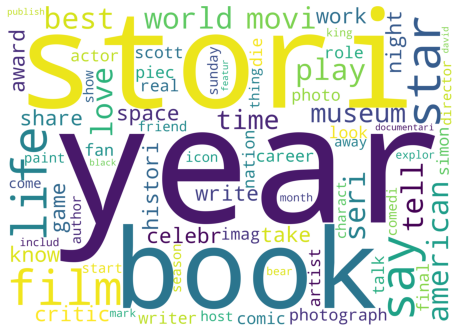


Wordcloud for topic: 1 



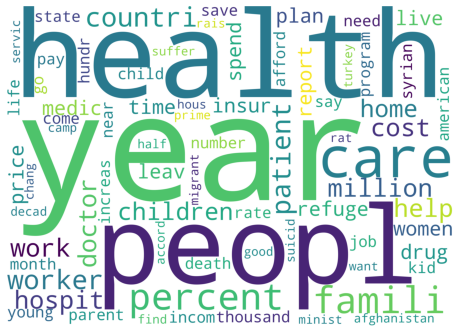


Wordcloud for topic: 2 



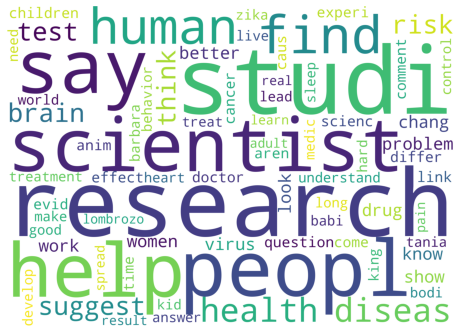


Wordcloud for topic: 3 



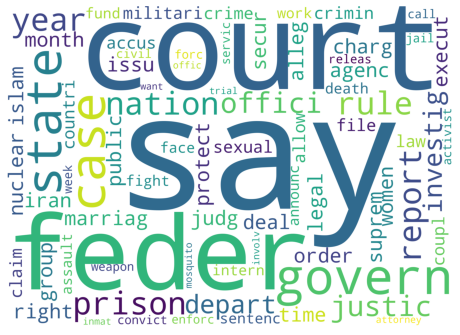


Wordcloud for topic: 4 



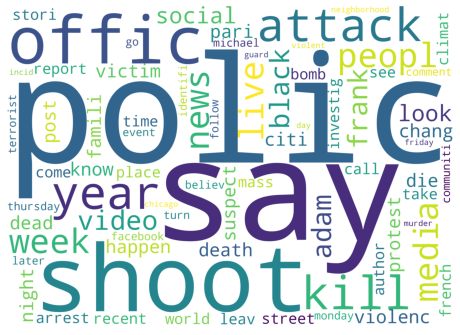


Wordcloud for topic: 5 



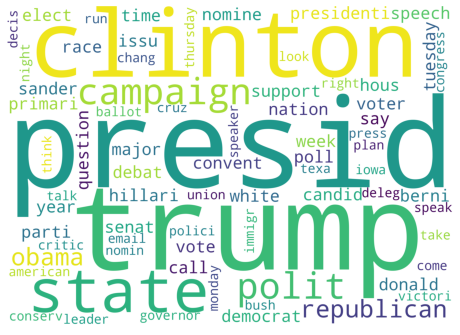


Wordcloud for topic: 6 



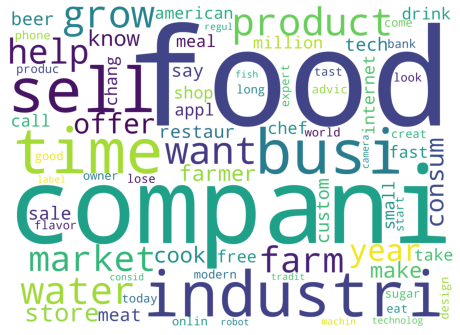


Wordcloud for topic: 7 



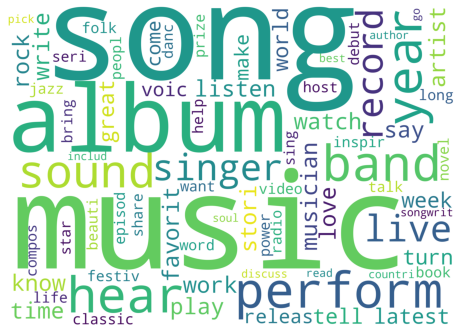


Wordcloud for topic: 8 



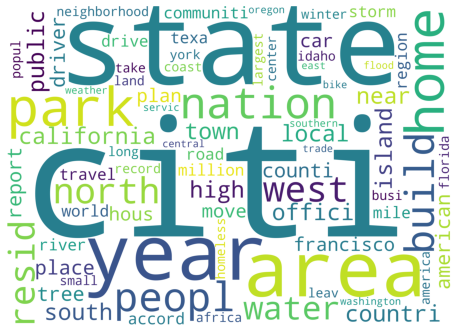


Wordcloud for topic: 9 



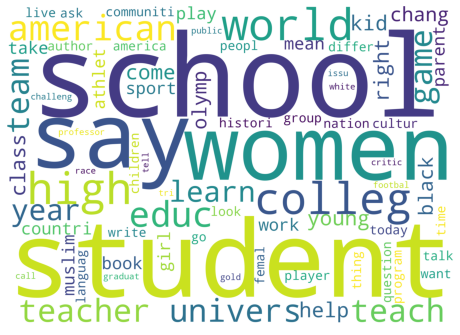

In [ ]:
for topic in range(10):
    #plt.figure(figsize=(10,15))
    word_cloud(topic, lda_model)

In [ ]:
df=pd.read_csv('/content/train.csv')

In [ ]:
# prompt: df is the dataframe give me the preprocessing steps

# Assuming 'df' is your DataFrame and the text column is named 'text'
# You might need to adjust the column name if it's different.

# Function to perform the pre processing steps on the entire dataset
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            #Apply lemmatize_stemming() on the token, then add to the results list
            result.append(lemmatize_stemming(token))
    return result

# Preprocess the text column
processed_docs = df['text'].map(lambda x: preprocess(x))


In [ ]:
df.head()

,title,label
0,20 BuzzFeed Articles It's Probably OK That I N...,clickbait
1,Pigskin A Blanket: NFL Conference Championship...,clickbait
2,When Relationship Introductions Get Awkward,clickbait
3,You Might Be Food Shopping Wrong,clickbait
4,27 Underrated Makeup Brands Everyone Should Kn...,clickbait


In [ ]:
# prompt: Make text classification model using  random forest for above text

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# Combine processed documents into a single string
documents['processed_caption'] = processed_docs.apply(lambda x: ' '.join(x))

# Create TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(documents['processed_caption']).toarray()

# Assuming you have labels for your data (replace 'labels' with your actual labels)
y = documents['your_label_column']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
classifier = RandomForestClassifier(n_estimators=10, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
